# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1$, $\alpha=2$) ($\tau$ slightly low)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau = 1
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

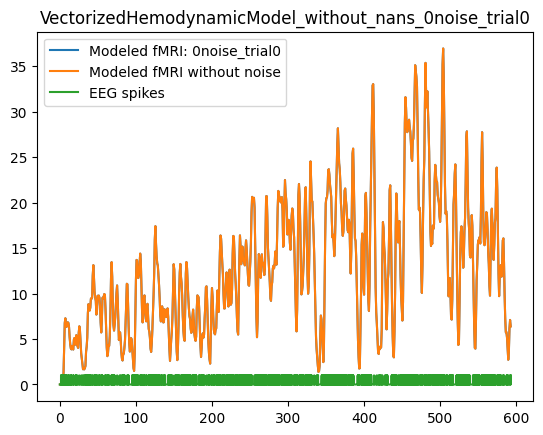

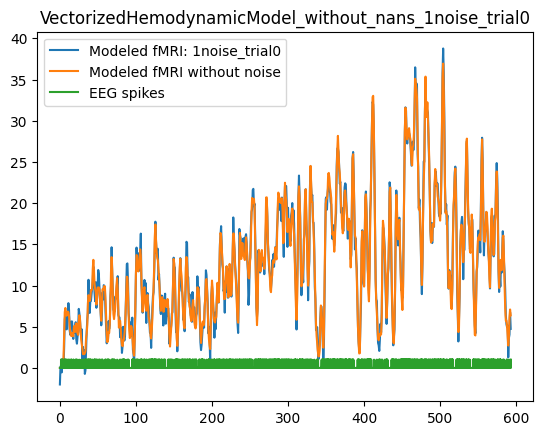

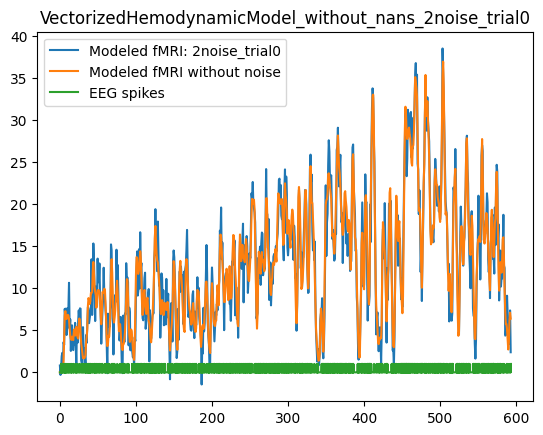

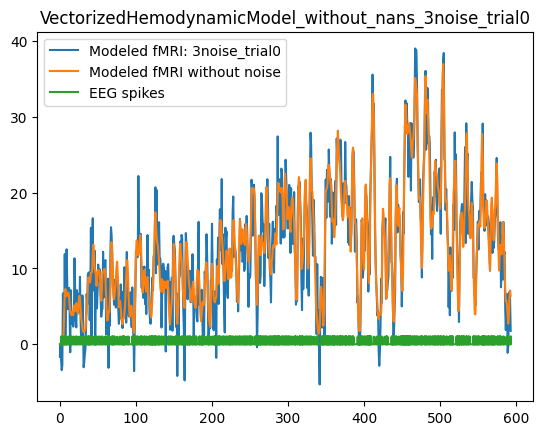

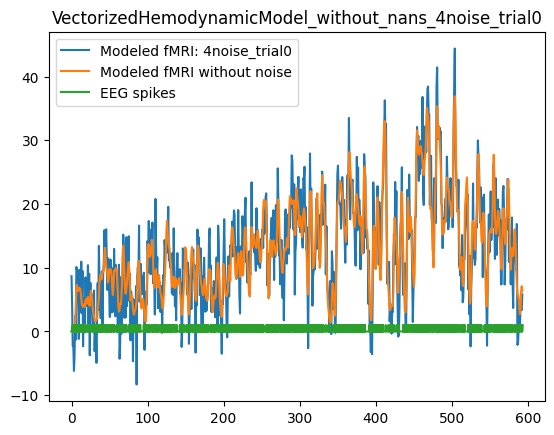

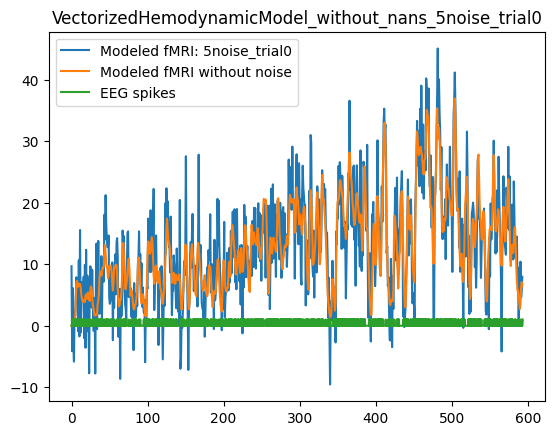

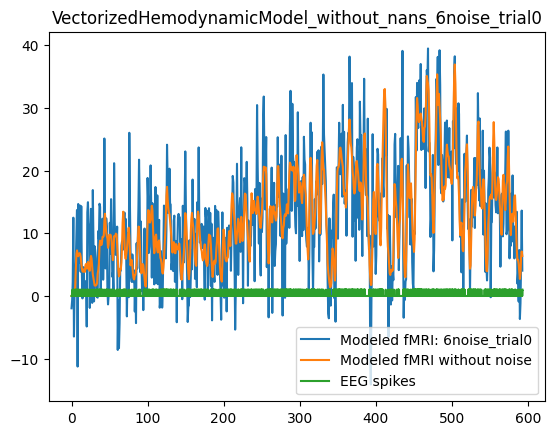

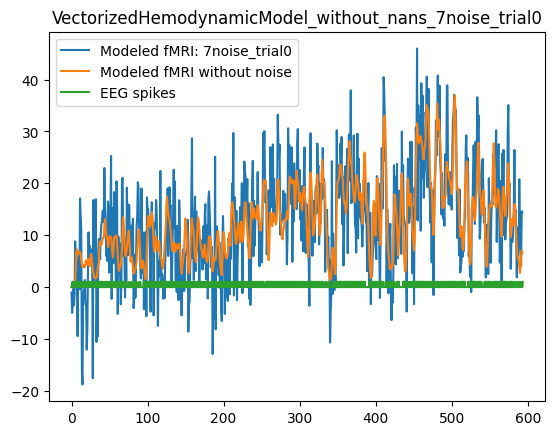

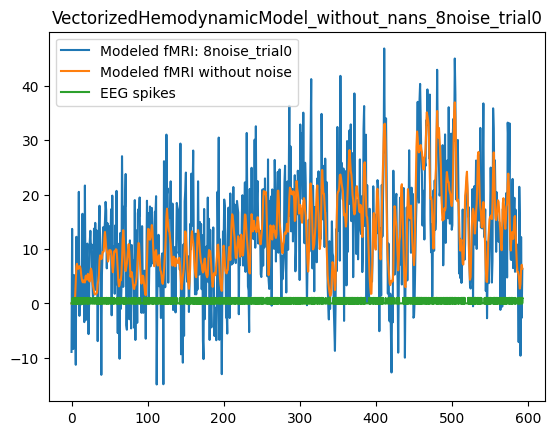

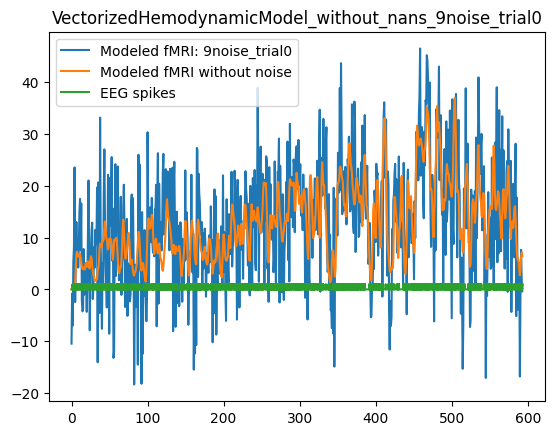

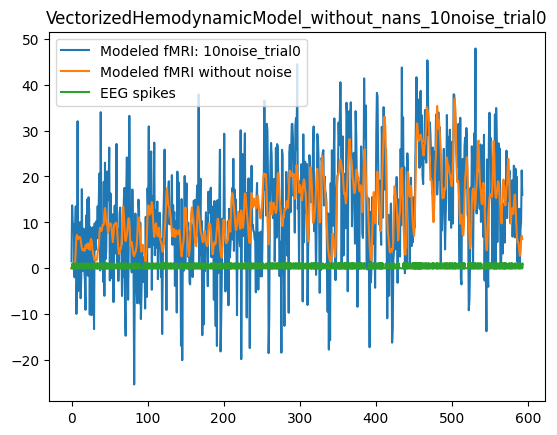

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1, alpha=2


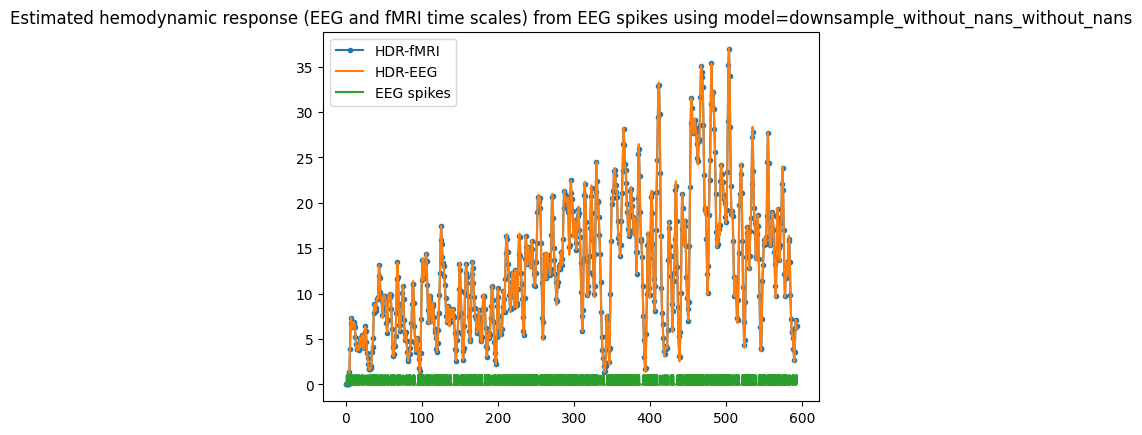

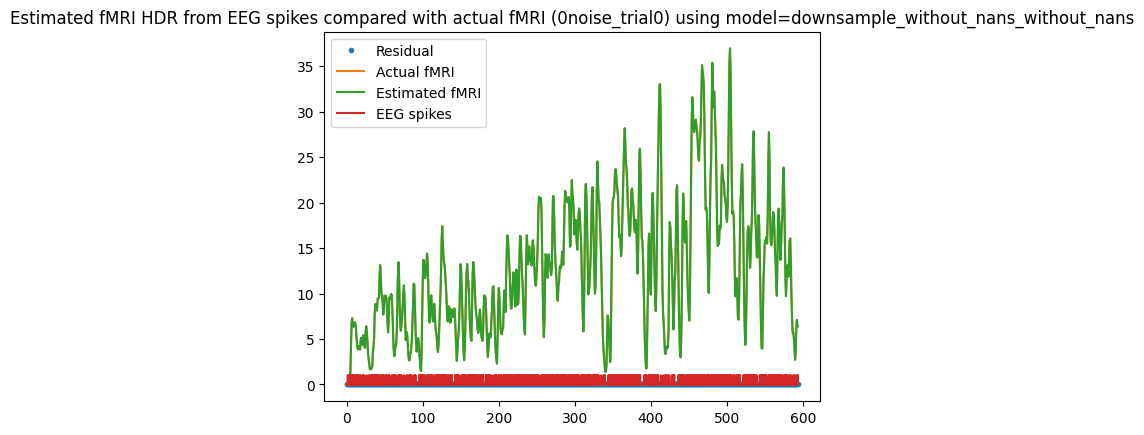

Residual Variance is 0.000000


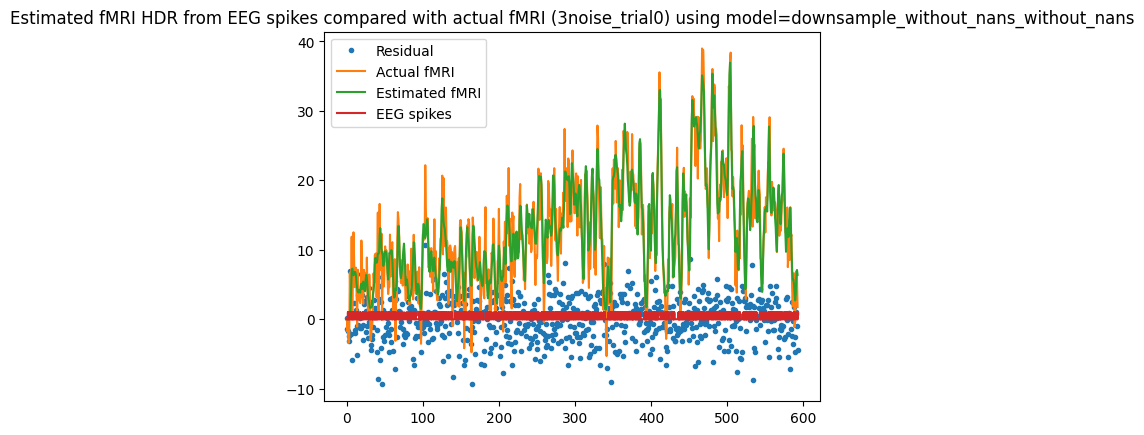

Residual Variance is 9.465790


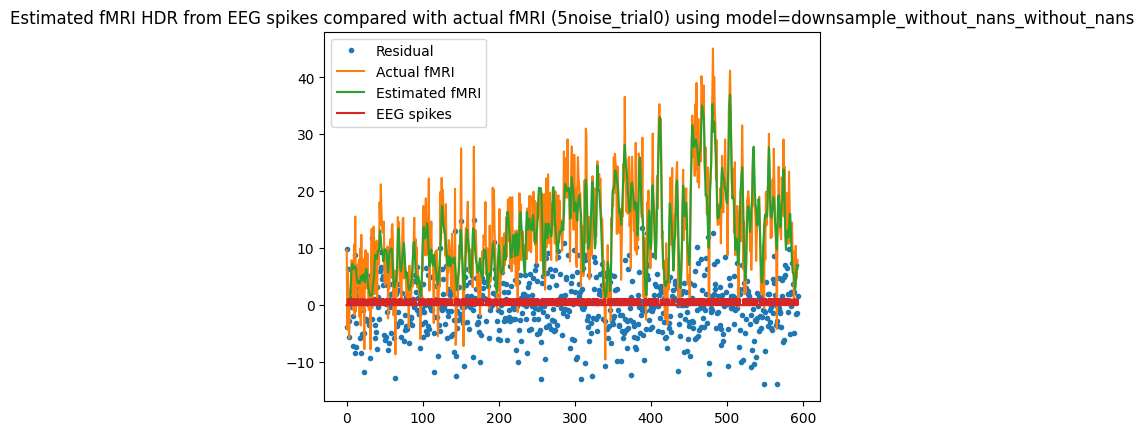

Residual Variance is 24.454481


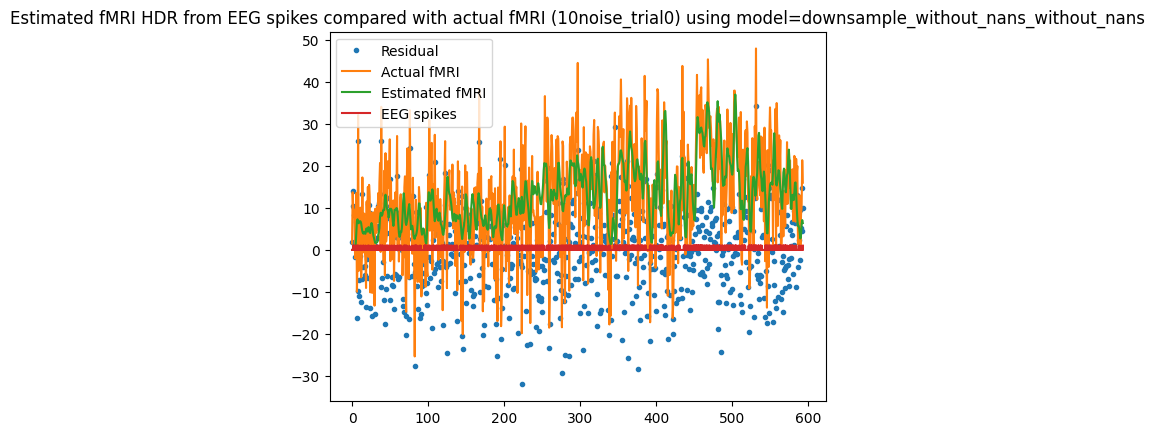

Residual Variance is 104.141876


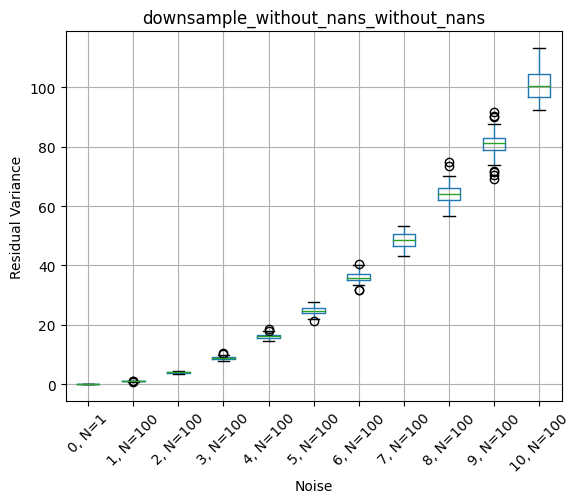

Scoring downsample_without_nans_with_nans delta=2.25, tau=1, alpha=2


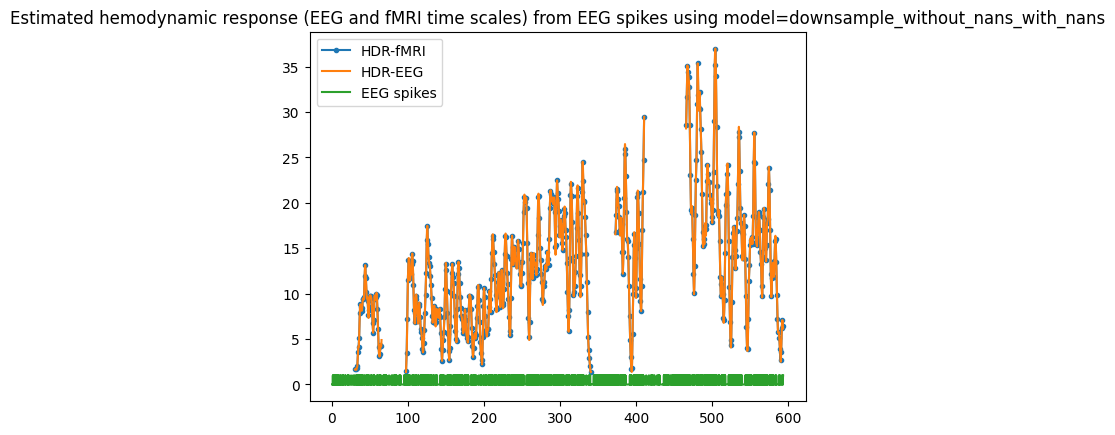

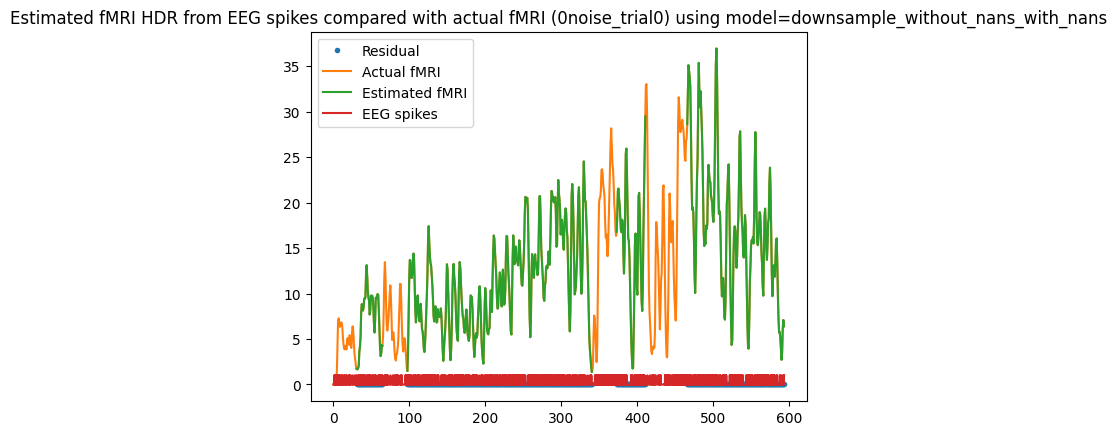

Residual Variance is 0.000000


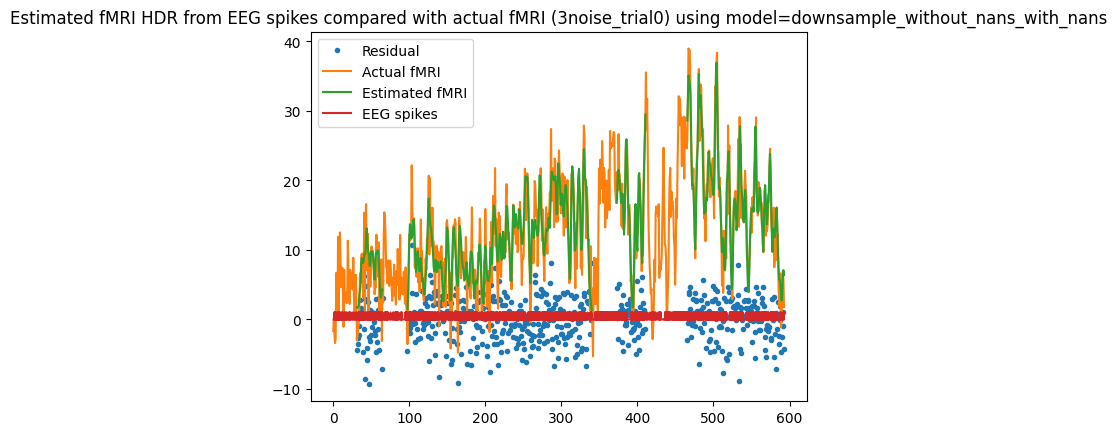

Residual Variance is 9.634964


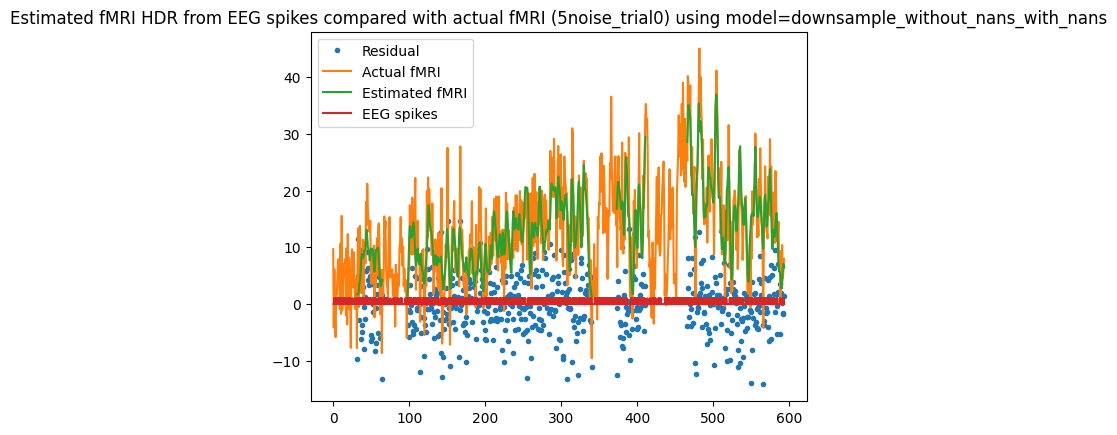

Residual Variance is 25.812882


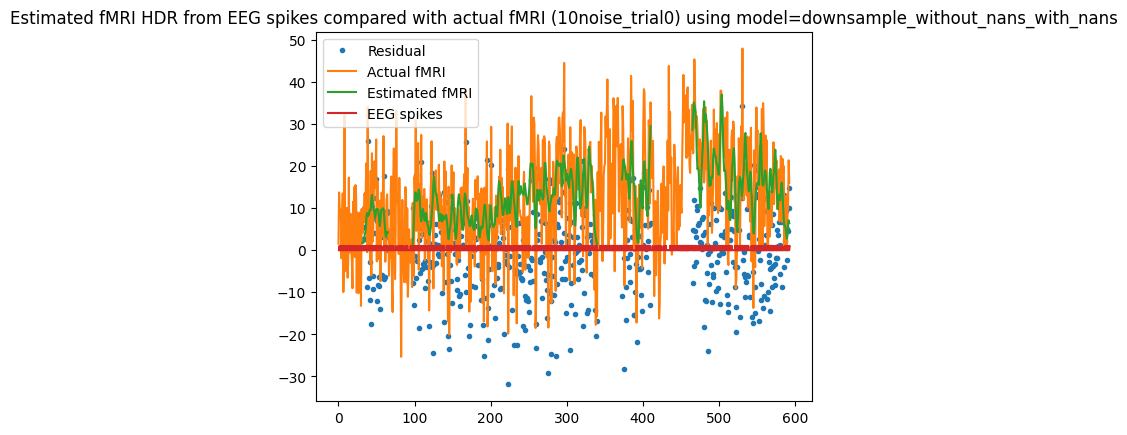

Residual Variance is 103.776165


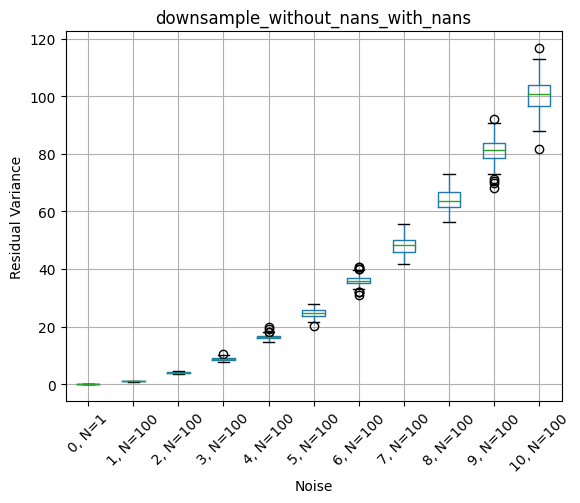

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   27.29502135800806   
1         downsample_without_nans_with_nans  25.651095883081865   
2      downsample_without_nans_without_nans   26.55315174839254   
3         downsample_without_nans_with_nans  24.992032212422313   
4      downsample_without_nans_without_nans  25.807681292763593   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  17.961178508749747   
18938  downsample_without_nans_without_nans  19.984566081452762   
18939     downsample_without_nans_with_nans  18.493803470926682   
18940  downsample_without_nans_without_nans  20.577650606473775   
18941     downsample_without_nans_with_nans  19.011884171713817   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       28.64794347248968  31.535792307461335   37.67539310303494   
1      27.414975891208847  29.677768581759167  37.019605814779005   
2      27.911814074641118   30.80089631216569  36.934468959450655   
3      26.752654743269535   29.02918309820579  36.343624892592665   
4       27.17174248513478  30.062548360057804   36.18968845975939   
...                   ...                 ...                 ...   
18937  18.836069768554108  22.159708960378257  26.745916453775866   
18938   20.42663650720813  23.958168602210076  28.246645681639674   
18939  19.377578752889036   22.69971789828598  27.297857820698088   
18940  21.016442598376692   24.55318582898317  28.854157131596136   
18941  19.904595998499133  23.225052786403495  27.836474421424164   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       43.98170949685943    54.0836236158581  ...  27.475587484262064   
1       41.25825127404641  53.415120548927206  ...  25.701859724124848   
2       43.23678800553254  53.296609069380196  ...  26.746281693679073   
3       40.60859863020955  52.748002564824404  ...  25.053349801054868   
4       42.48808286102804   52.50582249489043  ...  26.013763719983064   
...                   ...                 ...  ...                 ...   
18937   32.67313402412044   42.43002804320872  ...  19.063059982282926   
18938   35.25838747493327   44.64170614804298  ...  20.885256796622286   
18939   33.19579799931718  42.991838131059076  ...  19.589502280643067   
18940  35.842855001409276   45.27540709008862  ...  21.473222479745345   
18941   33.70543511870244  43.540864131409684  ...  20.101121469509348   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      31.658653335886832   37.94505921414927   42.18506993166838   
1       30.31557380763605   36.12925927497058   41.85557858578769   
2      30.944954680440848   37.17782072750003   41.44294408576421   
3       29.66995115758469  35.448059298441635   41.15109342466999   
4       30.22659479389911   36.40558516807582   40.69851127103455   
...                   ...                 ...                 ...   
18937  22.551510509201073   27.89831024241446   36.16010703481062   
18938  24.058107901678863  29.759419314761328  36.781859196536544   
18939  23.101992041197793  28.437050273427698  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.660064313999669e-28; at
       delta  tau  alpha
11670   2.25  1.0    2.0


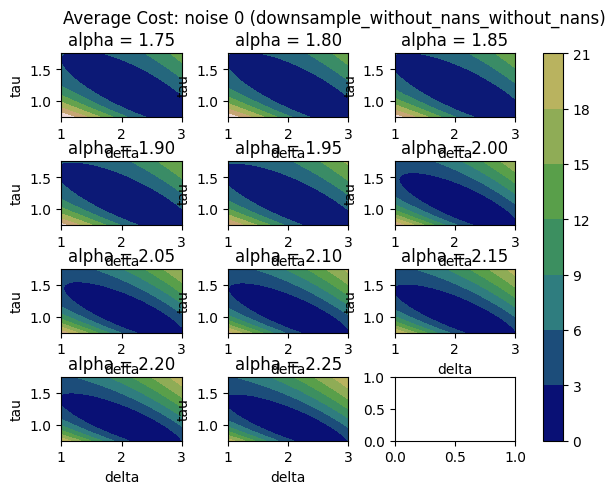

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              27.295021             
2                                              26.553152             
4                                              25.807681             
6                                              25.059455             
8                                              24.309334             
...                                                  ...             
18932                                          18.125154             
18934                                          18.757925             
18936                                          19.377873             
18938                                          19.984566             
18940                                          20.577651             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1, Alpha target: 2


delta  tau  alpha
0   2.25  1.0    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.587131e-03   2.15  0.95   2.25
1      0         0  2.660064e-28   2.25  1.00   2.00
2      0         0  4.680409e-03   2.30  1.05   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.003587   2.15  0.95   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 5.315712641053561e-28; at
       delta  tau  alpha
11671   2.25  1.0    2.0


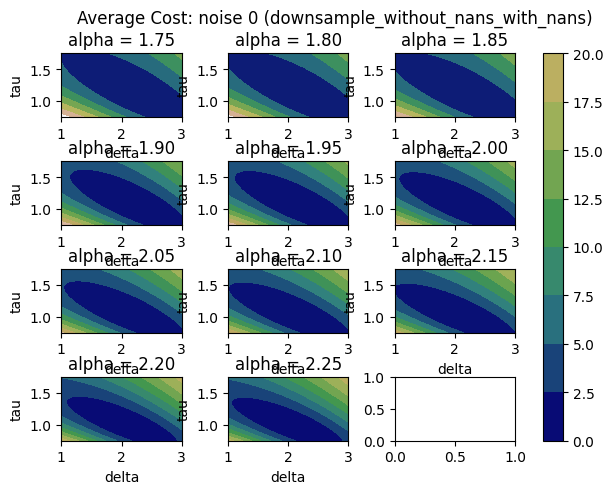

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              25.651096          
3                                              24.992032          
5                                              24.327209          
7                                              23.657386          
9                                              22.983351          
...                                                  ...          
18933                                          16.853290          
18935                                          17.414239          
18937                                          17.961179          
18939                                          18.493803          
18941                                          19.011884          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1, Alpha target: 2


delta  tau  alpha
0   2.25  1.0    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.727923e-03   2.15  0.95   2.25
1      0         0  5.315713e-28   2.25  1.00   2.00
2      0         0  4.282868e-03   2.30  1.05   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.003728   2.15  0.95   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9973874348367484; at
       delta  tau  alpha
11670   2.25  1.0    2.0


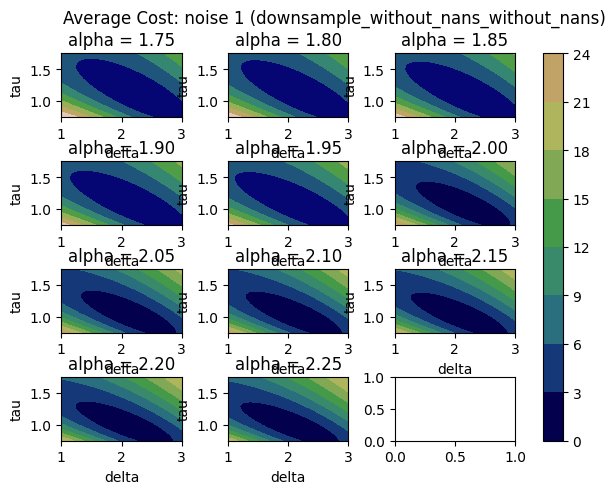

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.992169944170831; at
       delta  tau  alpha
11670   2.25  1.0    2.0


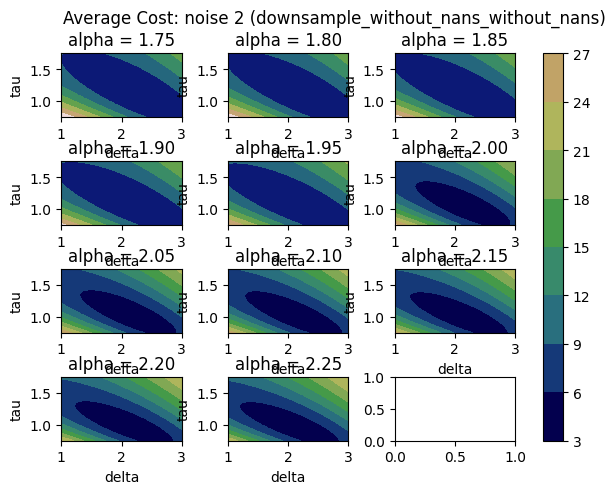

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.944492950416949; at
       delta  tau  alpha
11670   2.25  1.0    2.0


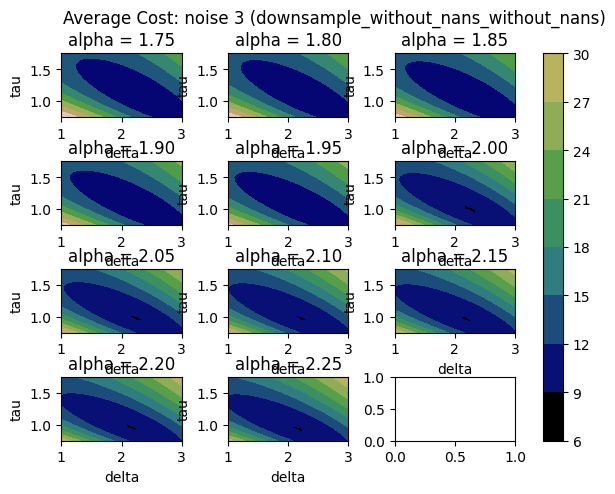

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.242647597587755; at
       delta  tau  alpha
11670   2.25  1.0    2.0


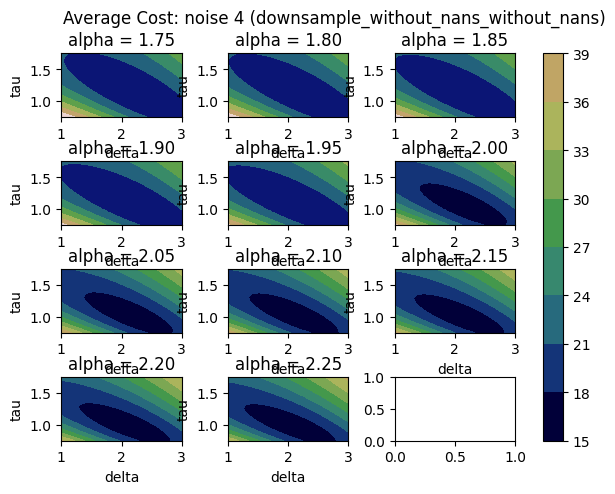

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.725088967976877; at
       delta  tau  alpha
12130    2.3  1.0   1.95


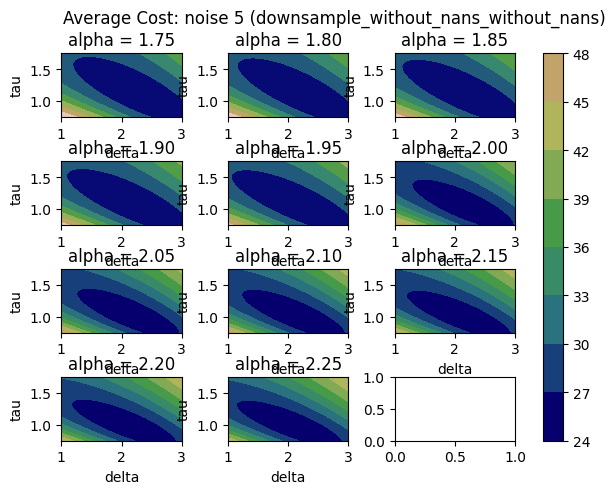

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.08208623599607; at
       delta  tau  alpha
12130    2.3  1.0   1.95


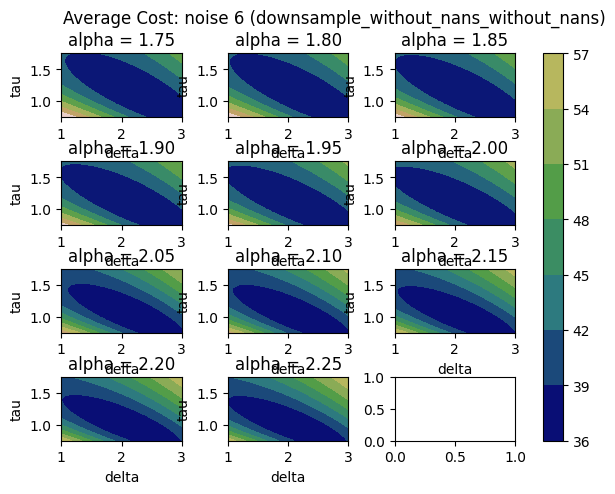

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.664857314332174; at
       delta  tau  alpha
11670   2.25  1.0    2.0


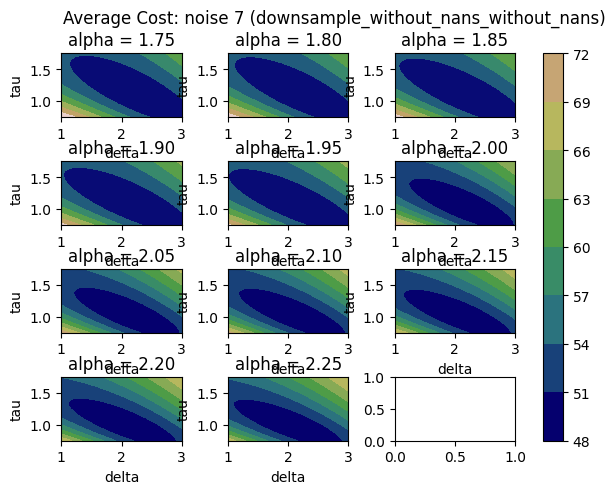

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.23824052473557; at
       delta   tau  alpha
10732   2.15  0.95    2.2


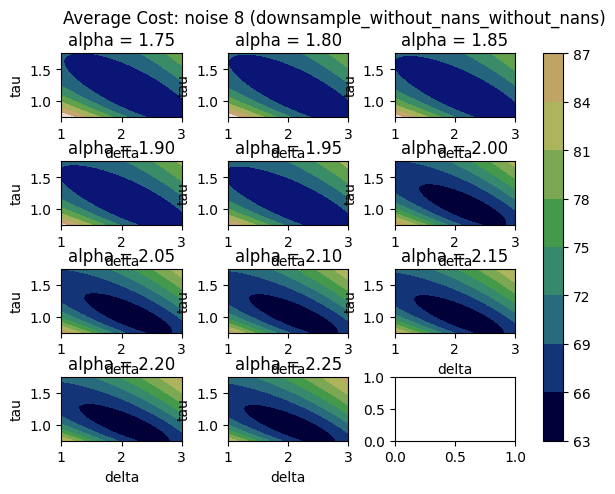

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.10132662218622; at
       delta  tau  alpha
11670   2.25  1.0    2.0


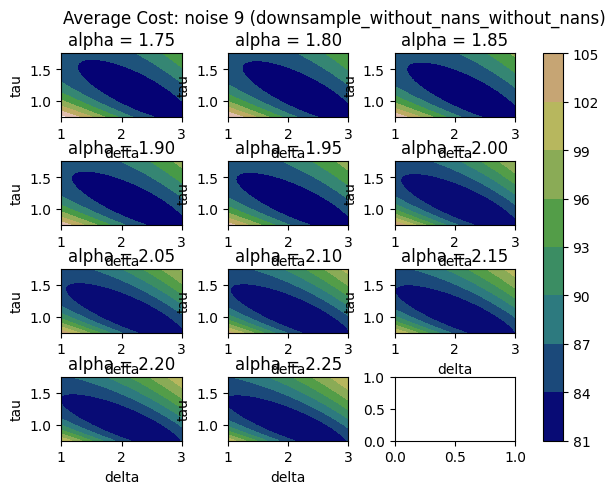

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.9355575088574; at
       delta  tau  alpha
12130    2.3  1.0   1.95


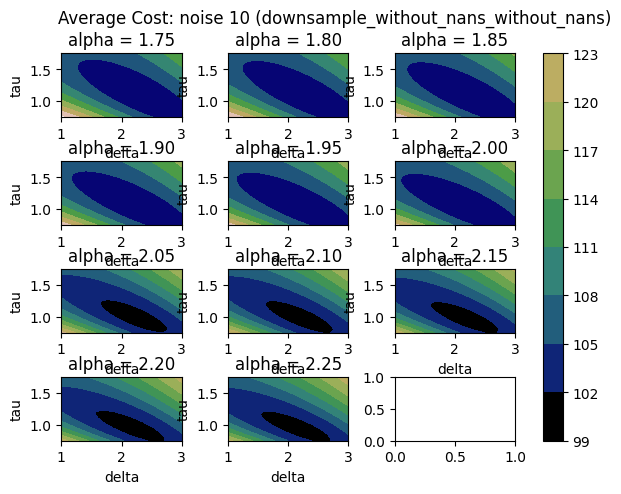

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

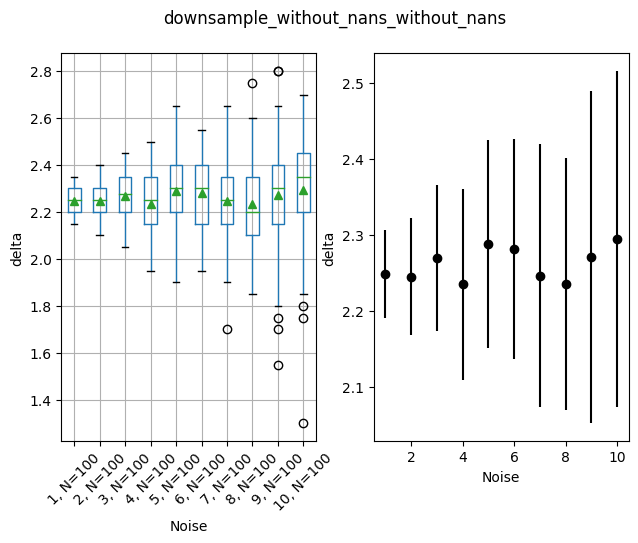

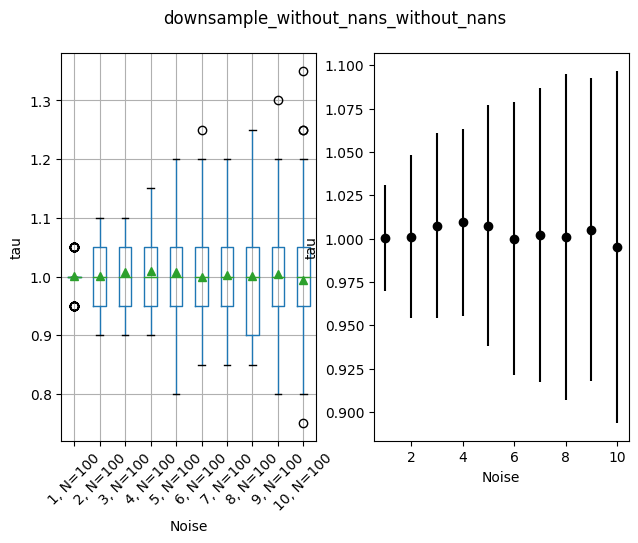

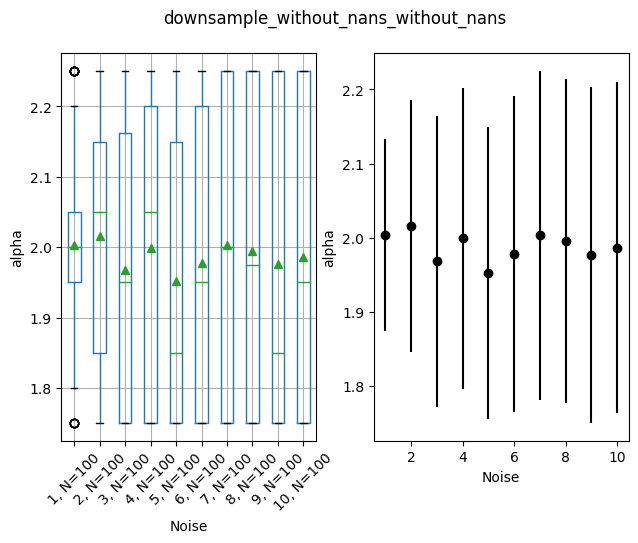

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9954820222606849; at
       delta  tau  alpha
11671   2.25  1.0    2.0


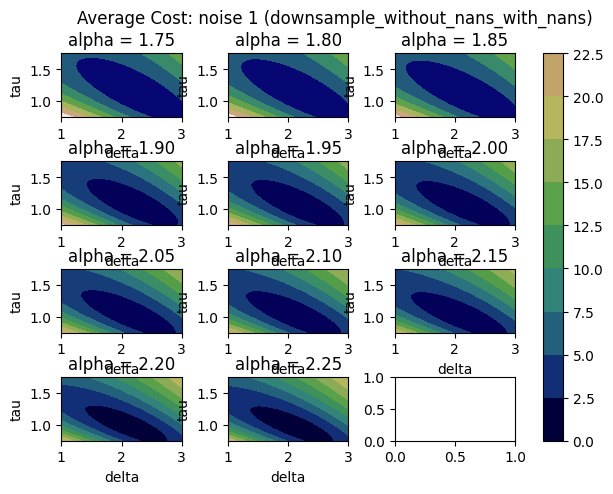

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.0039241132399725; at
       delta  tau  alpha
11671   2.25  1.0    2.0


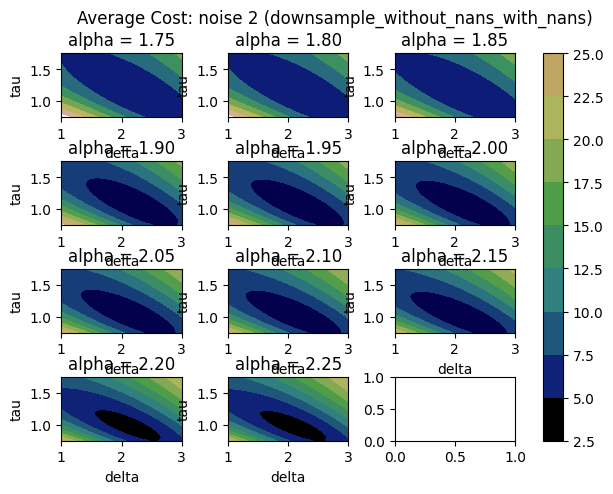

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.885115200256452; at
       delta  tau  alpha
11671   2.25  1.0    2.0


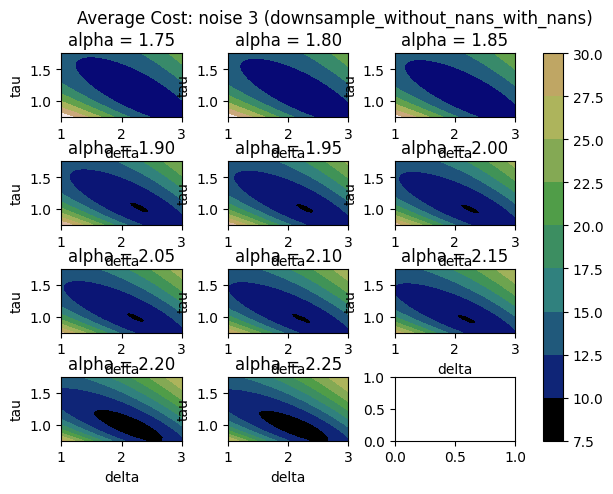

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.35194659503271; at
       delta  tau  alpha
11671   2.25  1.0    2.0


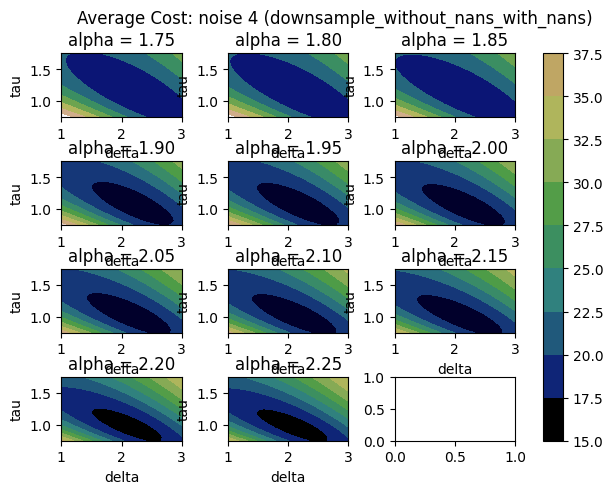

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.693698853105534; at
       delta  tau  alpha
11671   2.25  1.0    2.0


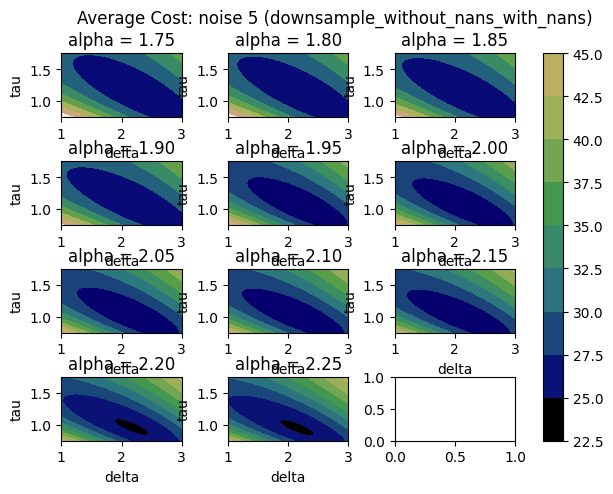

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.00455402554777; at
       delta  tau  alpha
12131    2.3  1.0   1.95


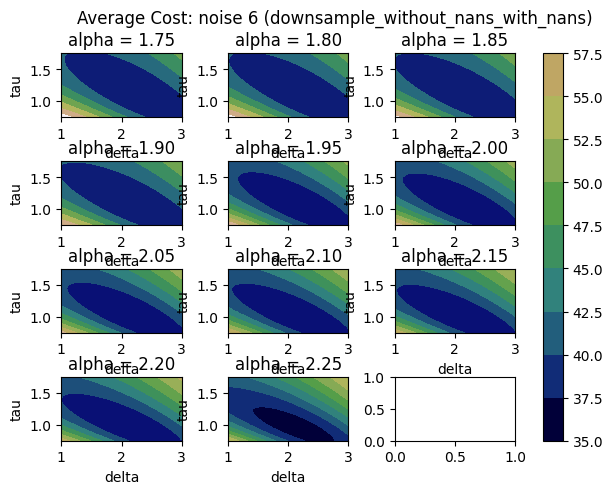

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.37130964815762; at
       delta  tau  alpha
11671   2.25  1.0    2.0


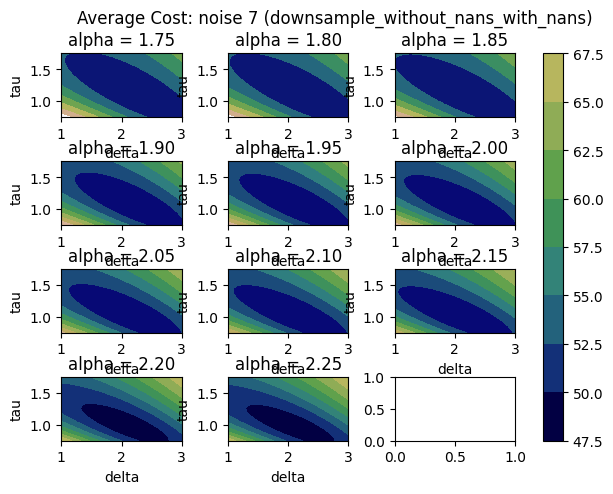

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.29441667417552; at
       delta   tau  alpha
12607   2.35  1.05   1.75


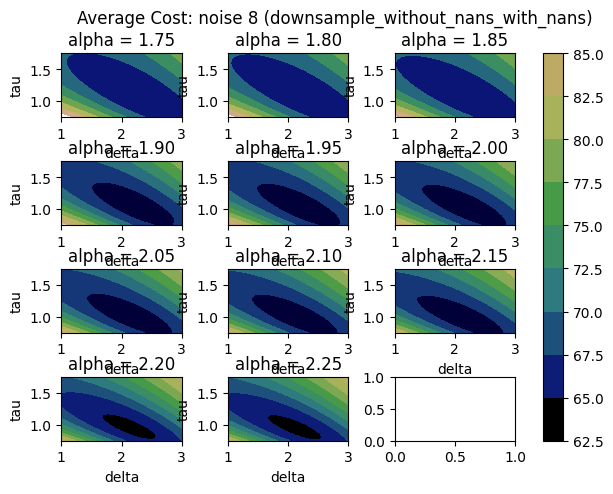

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.04807108747295; at
       delta   tau  alpha
12609   2.35  1.05    1.8


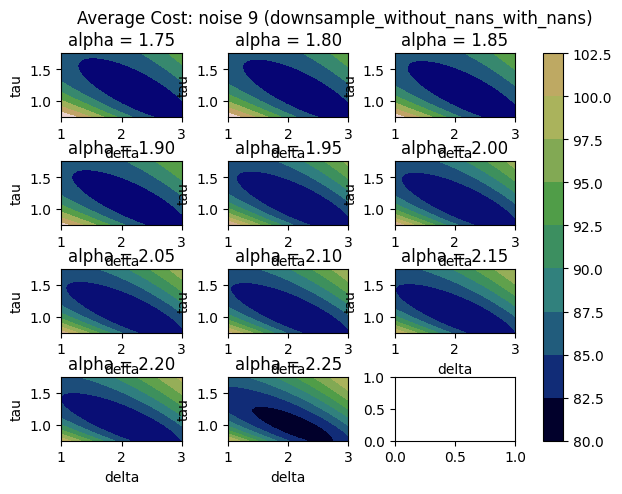

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.37678655060445; at
       delta   tau  alpha
13069    2.4  1.05   1.75


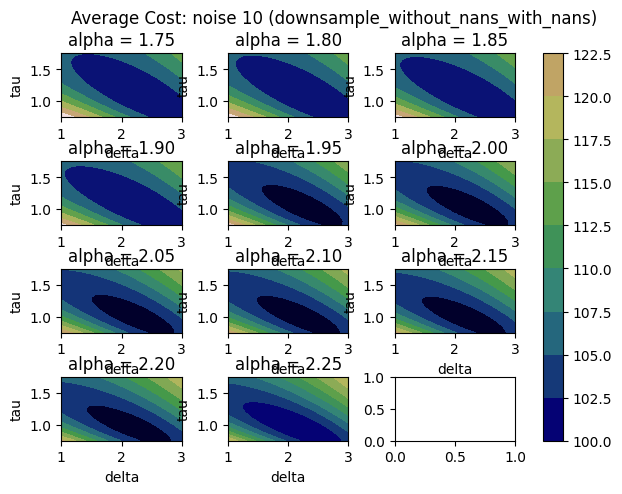

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


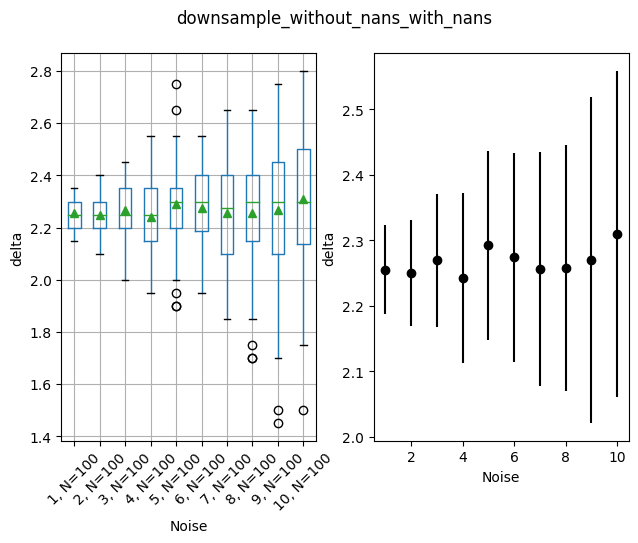

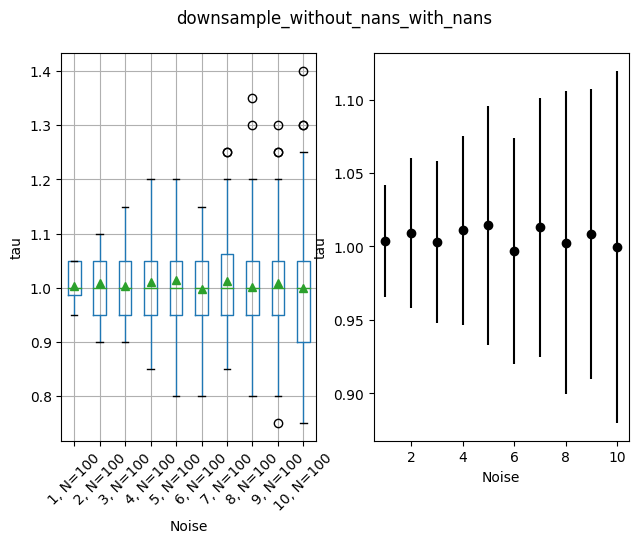

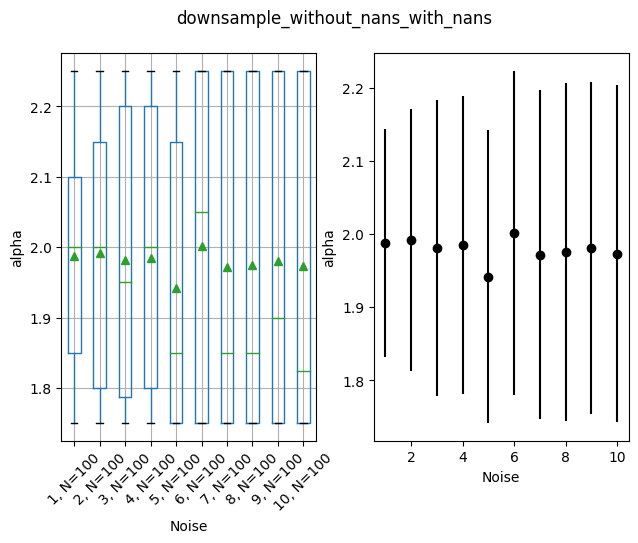

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        96    1.029937   2.100000000000001  0.9500000000000002   
1         1        22    1.069256  2.1500000000000012  0.9500000000000002   
2         1        33    0.962068  2.1500000000000012  0.9500000000000002   
3         1        60    0.992526  2.1500000000000012  0.9500000000000002   
4         1        71    1.041173  2.1500000000000012  0.9500000000000002   
...     ...       ...         ...                 ...                 ...   
2612     10        41   95.571326  2.6000000000000014  1.0000000000000002   
2613     10        43  106.091071  2.6000000000000014  1.0500000000000003   
2614     10        92  110.148138  2.6500000000000012  1.0500000000000003   
2615     10        16   94.692210  2.7000000000000015  0.9000000000000001   
2616     10        79  104.856340  2.7000000000000015  0.9500000000000002   

                   alpha  
0     2.2500000000000004  
1                    2.2  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2612  1.9000000000000001  
2613                1.75  
2614                1.75  
2615                1.75  
2616                1.75  

[2617 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  3.16  0.394917  3.0  3.0  3.0  3.00  5.0
2                      100.0  3.21  0.498381  2.0  3.0  3.0  3.25  4.0
3                      100.0  2.90  0.643538  1.0  3.0  3.0  3.00  4.0
4                      100.0  2.79  0.769297  1.0  2.0  3.0  3.00  4.0
5                      100.0  2.82  0.833394  1.0  2.0  3.0  3.00  5.0
6                      100.0  2.50  0.904534  1.0  2.0  3.0  3.00  4.0
7                      100.0  2.23  1.062254  1.0  1.0  2.0  3.00  4.0
8                      100.0  2.35  1.028631  1.0  1.0  2.0  3.00  5.0
9                      100.0  2.19  0.981598  1.0  1.0  2.0  3.00  5.0
10                     100.0  2.02  0.942595  1.0  1.0  2.0  3.00  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau  \
2336      9        34   78.116075  2.3500000000000014  0.75   
2535     10         2  106.309972  2.4000000000000012  0.75   
2562     10         6  102.575973   2.450000000000001  0.75   

                   alpha  
2336  2.2500000000000004  
2535                 2.2  
2562  2.1000000000000005

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
272       1        13    1.098606   2.300000000000001  1.1000000000000003   
273       1        49    0.990115   2.300000000000001  1.1000000000000003   
276       1         1    1.025475  2.3500000000000014  1.0500000000000003   
277       1         2    1.048561  2.3500000000000014  1.0500000000000003   
278       1         5    0.911406  2.3500000000000014  1.0500000000000003   
...     ...       ...         ...                 ...                 ...   
2611     10        90  106.208673  2.6000000000000014  0.9500000000000002   
2613     10        43  106.091071  2.6000000000000014  1.0500000000000003   
2614     10        92  110.148138  2.6500000000000012  1.0500000000000003   
2615     10        16   94.692210  2.7000000000000015  0.9000000000000001   
2616     10        79  104.856340  2.7000000000000015  0.9500000000000002   

     alpha  
272   1.75  
273   1.75  
276   1.75  
277   1.75  
278   1.75  
...    ...  
2611  1.75  
2613  1.75  
2614  1.75  
2615  1.75  
2616  1.75  

[431 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        20      3  2.3500000000000014   16    20      2  1.0500000000000003   
10       46     13  2.5000000000000013   10    46      9  1.0500000000000003   
2        44      4  2.3500000000000014   14    44      3  1.0500000000000003   
3        46      5  2.3500000000000014   20    46      4  1.0500000000000003   
4        45      7  2.3500000000000014   13    45      4  1.1000000000000003   
5        53     10   2.450000000000001   14    53      6  1.0500000000000003   
6        47     10   2.450000000000001   11    47      7  1.0500000000000003   
7        37     10  2.3500000000000014   10    37      6  1.1000000000000003   
8        47     12   2.200000000000001    9    47      8  1.1000000000000003   
9        46     13   2.300000000000001    9    46      9  1.0000000000000002   

            
      freq  
noise       
1       18  
10      17  
2       22  
3       23  
4       19  
5       21  
6       14  
7       10  
8       12  
9       12

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        96    1.029937   2.100000000000001  0.9500000000000002   
6         1         3    0.990705  2.1500000000000012  0.9500000000000002   
7         1         4    0.951804  2.1500000000000012  0.9500000000000002   
8         1         8    1.133768  2.1500000000000012  0.9500000000000002   
9         1         9    0.987195  2.1500000000000012  0.9500000000000002   
...     ...       ...         ...                 ...                 ...   
2565     10        47   99.112212   2.450000000000001  0.8500000000000001   
2570     10         7  105.478030   2.450000000000001  0.9000000000000001   
2581     10        41   95.554582  2.5000000000000013  0.9000000000000001   
2587     10        68   95.394989  2.5000000000000013  0.9500000000000002   
2609     10        68   95.388023  2.6000000000000014  0.9000000000000001   

                   alpha  
0     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
8     2.2500000000000004  
9     2.2500000000000004  
...                  ...  
2565  2.2500000000000004  
2570  2.2500000000000004  
2581  2.2500000000000004  
2587  2.2500000000000004  
2609  2.2500000000000004  

[454 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        58      4  2.1500000000000012   55    58      2  0.9500000000000002   
10       42     17   2.300000000000001    6    42      8  0.9000000000000001   
2        50      4  2.1500000000000012   34    50      3  0.9500000000000002   
3        36      6   2.200000000000001   17    36      3  0.9500000000000002   
4        43      8   2.200000000000001    9    43      5  0.9500000000000002   
5        44     10   2.200000000000001   11    44      6  0.9500000000000002   
6        37     13  2.1500000000000012    9    37      6  0.9500000000000002   
7        50     13  2.0500000000000007    6    50      7  0.9000000000000001   
8        49     13  2.0500000000000007   10    49      6  1.0000000000000002   
9        45     14   2.100000000000001    8    45      9  0.9500000000000002   

            
      freq  
noise       
1       57  
10      10  
2       45  
3       24  
4       21  
5       16  
6       14  
7       14  
8       14  
9       14

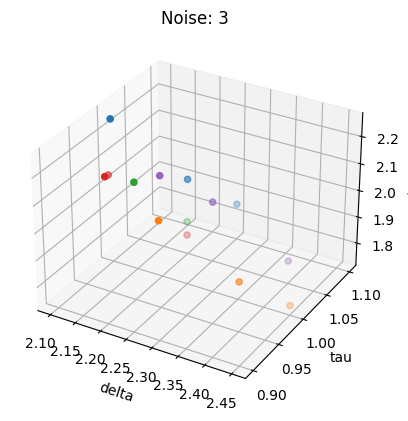

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

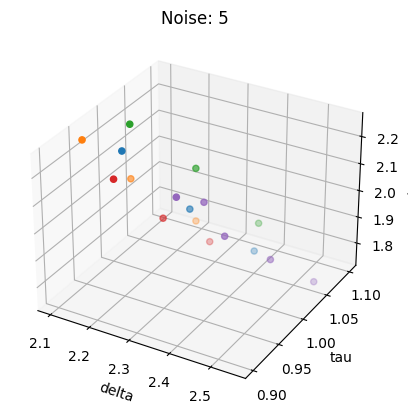

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

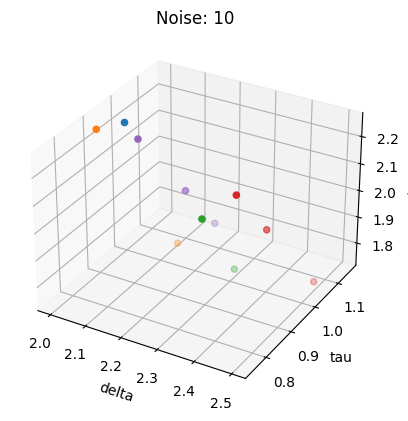

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        33    1.005914   2.100000000000001  0.9500000000000002   
1         1        96    1.039952   2.100000000000001  0.9500000000000002   
2         1         5    0.903224  2.1500000000000012  0.9500000000000002   
3         1         7    1.029778  2.1500000000000012  0.9500000000000002   
4         1        12    1.065388  2.1500000000000012  0.9500000000000002   
...     ...       ...         ...                 ...                 ...   
2531     10        90  101.363817  2.7000000000000015  0.8500000000000001   
2532     10        97  103.250134  2.7000000000000015  1.0000000000000002   
2533     10        47  102.734892  2.7500000000000018                0.75   
2534     10        16   92.751197  2.8000000000000016  0.8500000000000001   
2535     10        79   99.941308  2.8000000000000016  0.9500000000000002   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2531                1.85  
2532                1.75  
2533  2.2500000000000004  
2534                1.75  
2535                1.75  

[2536 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min   25%  50%  75%  max
noise                                                                 
1                      100.0  3.08  0.393893  2.0  3.00  3.0  3.0  4.0
2                      100.0  3.11  0.490207  2.0  3.00  3.0  3.0  4.0
3                      100.0  2.77  0.763498  1.0  2.00  3.0  3.0  5.0
4                      100.0  2.75  0.796140  1.0  2.75  3.0  3.0  4.0
5                      100.0  2.63  1.031376  1.0  2.00  3.0  3.0  4.0
6                      100.0  2.47  0.999545  1.0  2.00  3.0  3.0  5.0
7                      100.0  2.26  1.069504  1.0  1.00  2.0  3.0  5.0
8                      100.0  2.18  1.076658  1.0  1.00  2.0  3.0  5.0
9                      100.0  2.04  1.043692  1.0  1.00  2.0  3.0  4.0
10                     100.0  2.07  1.056533  1.0  1.00  2.0  3.0  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau  \
1989      8        24   67.932039   2.250000000000001  0.75   
2291      9        34   75.969218  2.5000000000000013  0.75   
2460     10         2  106.312827   2.450000000000001  0.75   
2461     10         6  101.512767   2.450000000000001  0.75   
2480     10         2  106.311534  2.5000000000000013  0.75   
2494     10         6  101.499909  2.5500000000000016  0.75   
2510     10         6  101.495687  2.6000000000000014  0.75   
2533     10        47  102.734892  2.7500000000000018  0.75   

                   alpha  
1989  2.2500000000000004  
2291  1.9500000000000002  
2460  2.1500000000000004  
2461                 2.2  
2480  2.0500000000000003  
2494  2.0500000000000003  
2510  1.9500000000000002  
2533  2.2500000000000004

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
252       1        49    0.973286   2.300000000000001  1.1000000000000003   
253       1        69    0.996087   2.300000000000001  1.1000000000000003   
254       1        82    0.970222   2.300000000000001  1.1000000000000003   
255       1        83    0.868587   2.300000000000001  1.1000000000000003   
256       1        87    1.104702   2.300000000000001  1.1000000000000003   
...     ...       ...         ...                 ...                 ...   
2526     10        95  104.168425  2.6500000000000012  0.9000000000000001   
2530     10        92  111.566656  2.6500000000000012  1.1000000000000003   
2532     10        97  103.250134  2.7000000000000015  1.0000000000000002   
2534     10        16   92.751197  2.8000000000000016  0.8500000000000001   
2535     10        79   99.941308  2.8000000000000016  0.9500000000000002   

     alpha  
252   1.75  
253   1.75  
254   1.75  
255   1.75  
256   1.75  
...    ...  
2526  1.75  
2530  1.75  
2532  1.75  
2534  1.75  
2535  1.75  

[462 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        28      3  2.3500000000000014   18    28      2  1.0500000000000003   
10       54     14  2.5500000000000016    7    54     12  1.0500000000000003   
2        48      5   2.300000000000001   15    48      3  1.0500000000000003   
3        42      5   2.300000000000001   13    42      4  1.0500000000000003   
4        44      9   2.300000000000001   11    44      6  1.0500000000000003   
5        58     10   2.300000000000001   15    58      5  1.0500000000000003   
6        42      9  2.3500000000000014   10    42      6  1.0500000000000003   
7        44     12  2.3500000000000014    9    44      8  1.0500000000000003   
8        53     15  2.3500000000000014   10    53     10  1.0500000000000003   
9        49     13  2.3500000000000014    8    49      9  1.0500000000000003   

            
      freq  
noise       
1       22  
10      12  
2       25  
3       22  
4       20  
5       19  
6       15  
7       11  
8       15  
9       12

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        33    1.005914   2.100000000000001  0.9500000000000002   
1         1        96    1.039952   2.100000000000001  0.9500000000000002   
14        1         4    0.925894  2.1500000000000012  0.9500000000000002   
15        1         8    1.101904  2.1500000000000012  0.9500000000000002   
16        1         9    1.000023  2.1500000000000012  0.9500000000000002   
...     ...       ...         ...                 ...                 ...   
2453     10        62   97.226782  2.4000000000000012  0.9000000000000001   
2472     10        41  100.035739   2.450000000000001  0.9500000000000002   
2482     10        35   91.461707  2.5000000000000013  0.8500000000000001   
2487     10         3  104.846263  2.5000000000000013  0.9000000000000001   
2533     10        47  102.734892  2.7500000000000018                0.75   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
14    2.2500000000000004  
15    2.2500000000000004  
16    2.2500000000000004  
...                  ...  
2453  2.2500000000000004  
2472  2.2500000000000004  
2482  2.2500000000000004  
2487  2.2500000000000004  
2533  2.2500000000000004  

[423 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        34      3  2.1500000000000012   31    34      1  0.9500000000000002   
10       45     18  2.0500000000000007    6    45      8  0.8500000000000001   
2        39      6  2.1500000000000012   22    39      3  0.9500000000000002   
3        35      6  2.1500000000000012   15    35      3  0.9500000000000002   
4        41      8   2.100000000000001   10    41      5  0.9500000000000002   
5        40     10   2.250000000000001    8    40      6  0.9000000000000001   
6        42     12  2.0500000000000007    8    42      7  0.9000000000000001   
7        49     15   2.250000000000001    8    49      8  0.9500000000000002   
8        46     14   2.200000000000001    7    46      9  0.9000000000000001   
9        52     19  2.3500000000000014    7    52     10  0.9000000000000001   

            
      freq  
noise       
1       34  
10       9  
2       35  
3       21  
4       18  
5       13  
6       14  
7       13  
8       14  
9       13

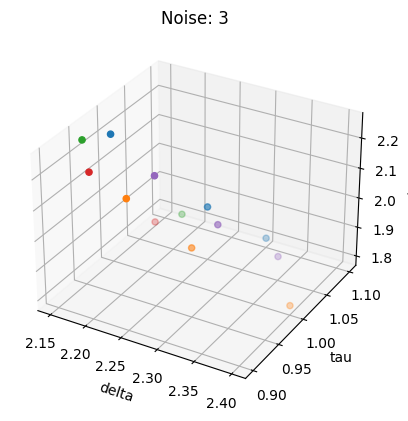

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

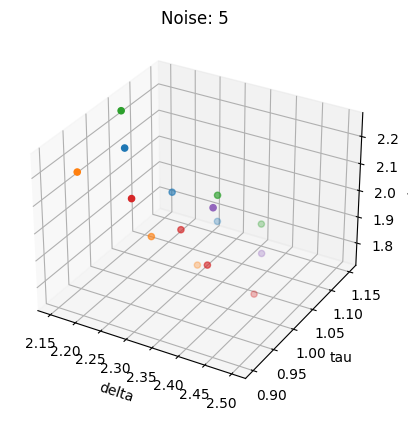

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

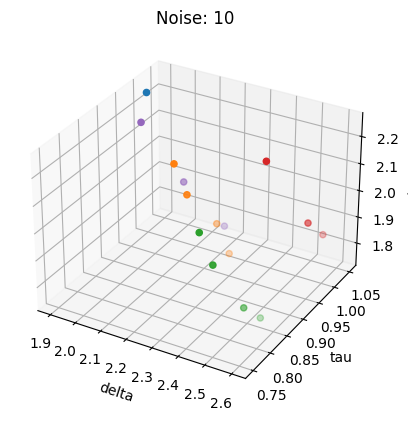

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()